In [1]:
# utility stuff
from pathlib import Path
import matplotlib.pyplot as pp

# eda stuff
import numpy as np
import pandas as pd
import seaborn as sb

# modeling stuff
import arviz as az
import pymc as pm

In [2]:
data  = Path.cwd() / 'data' / "concrete.csv"

df = pd.read_csv(data)

In [3]:
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


0. EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   fly_ash           1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarse_aggregate  1030 non-null   float64
 6   fine_aggregate    1030 non-null   float64
 7   age               1030 non-null   int64  
 8   strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [5]:
df.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


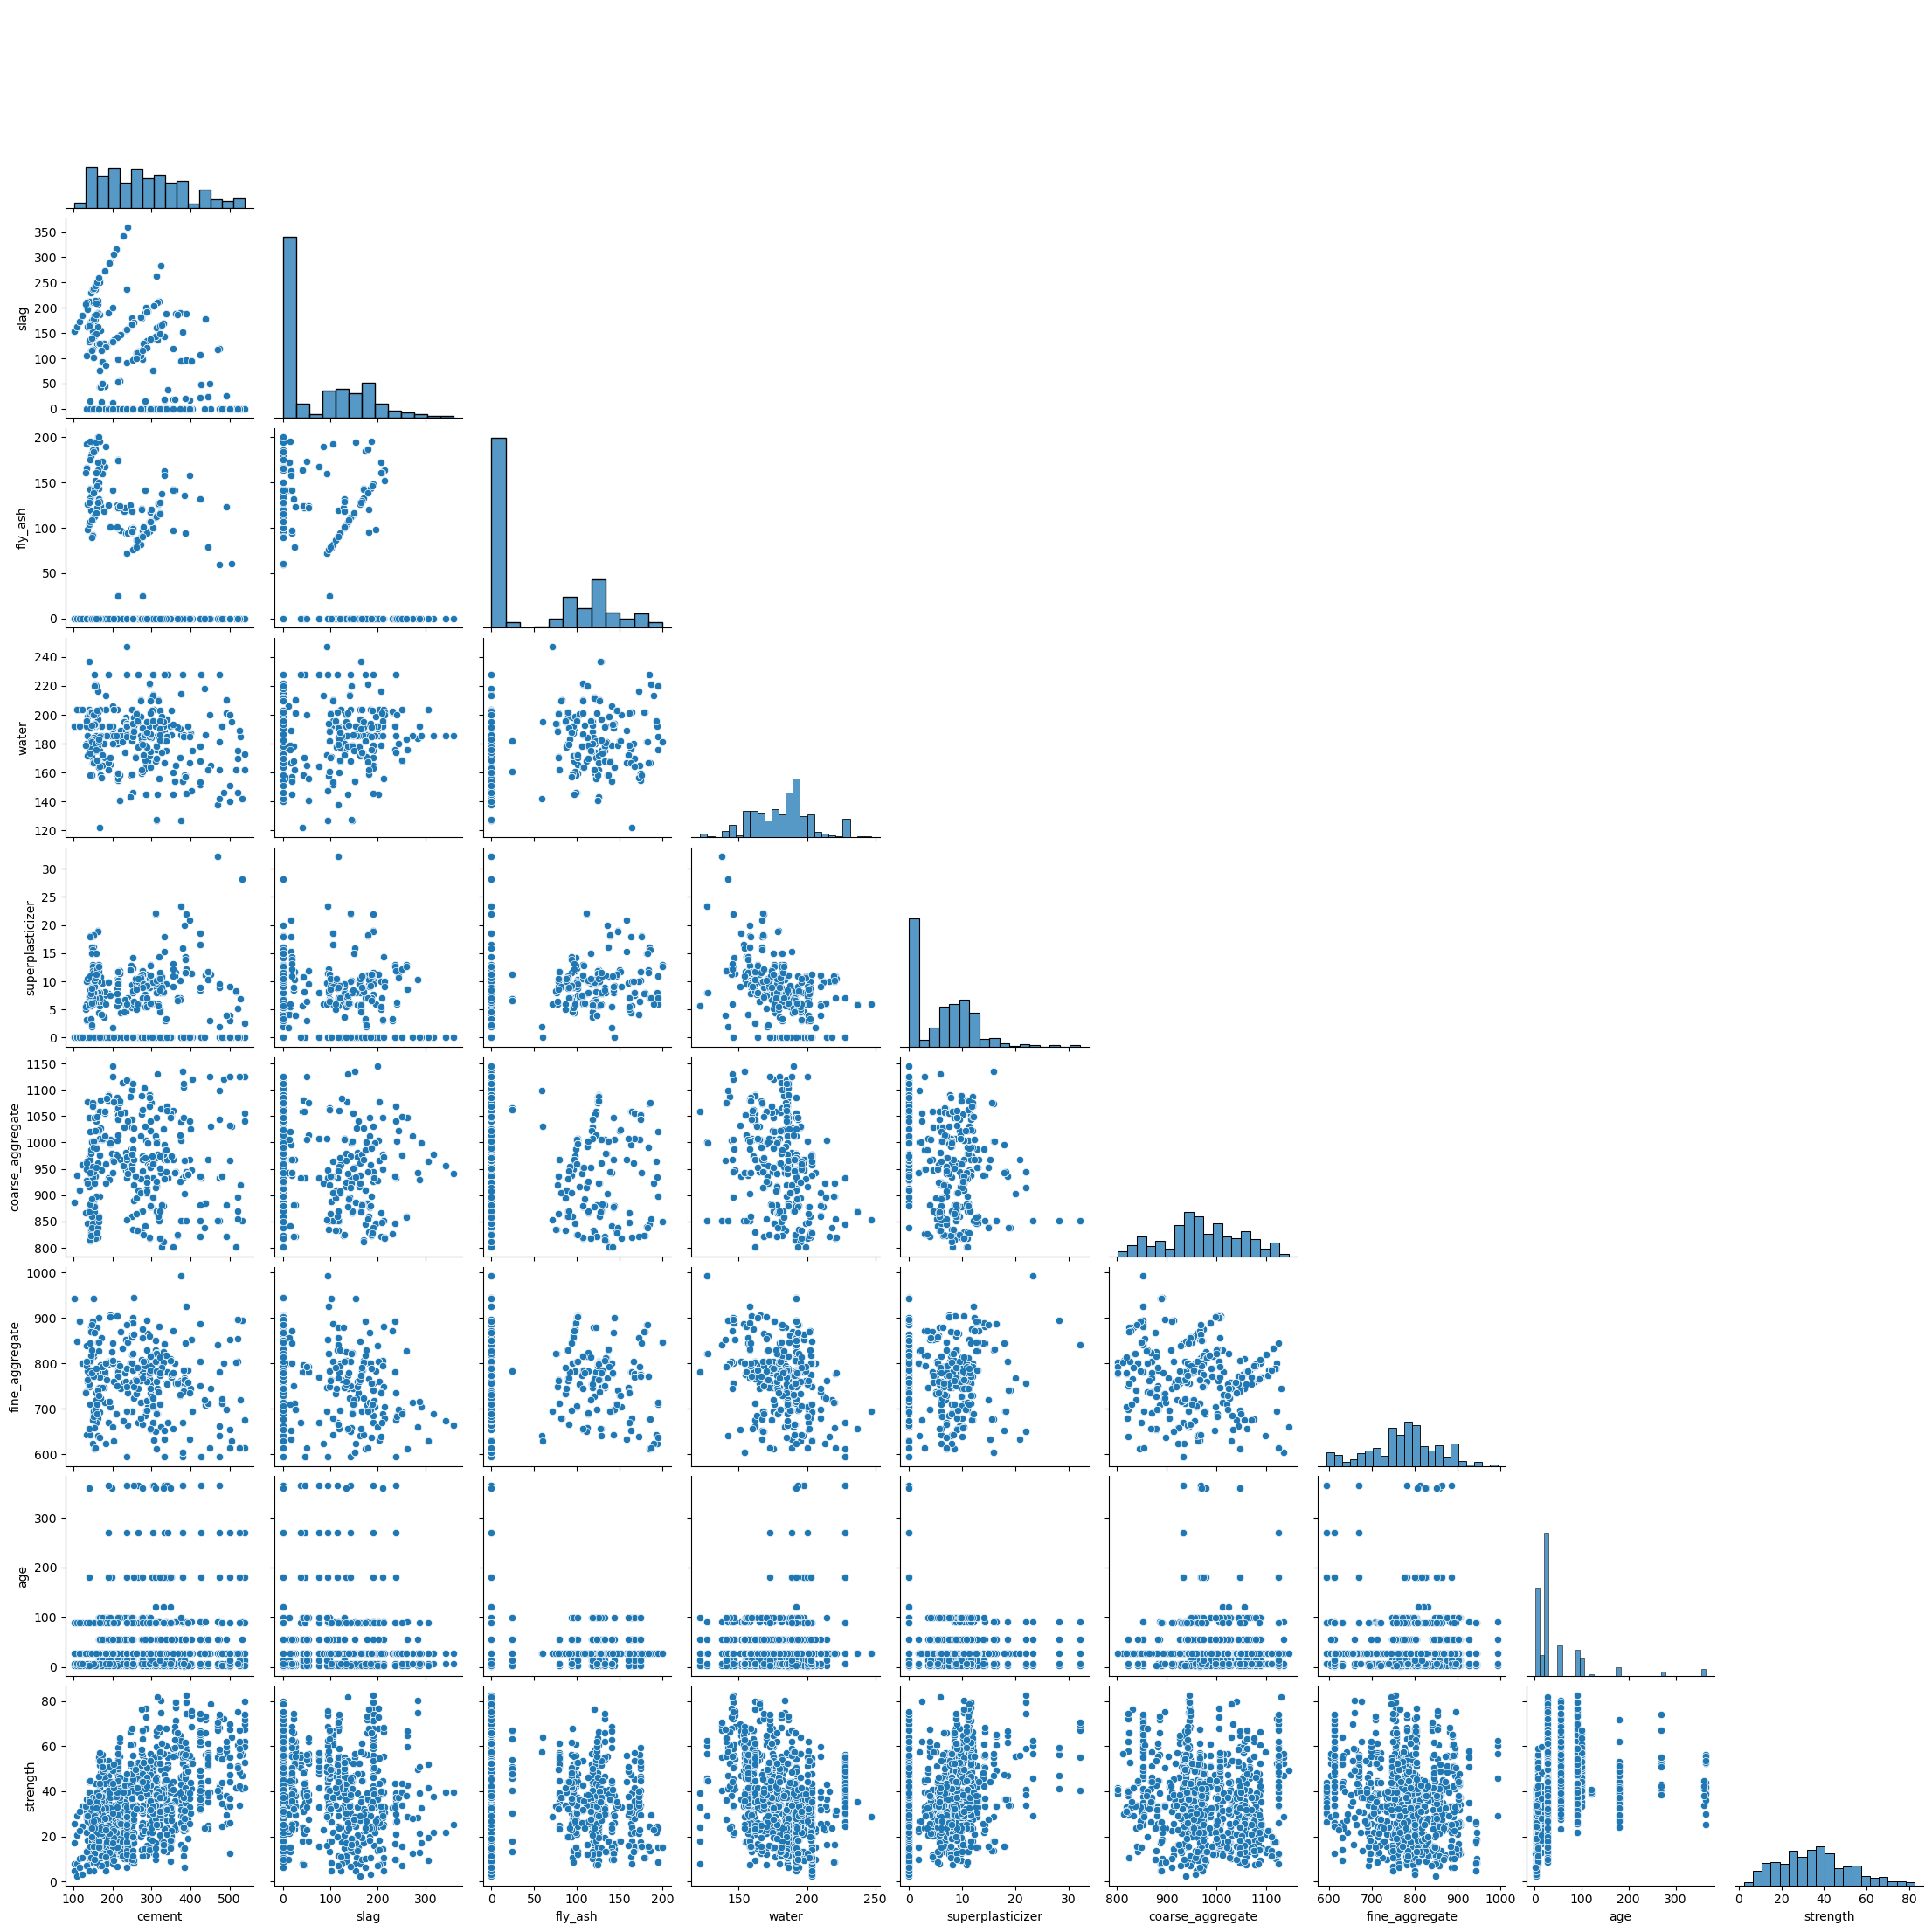

In [6]:
sb.pairplot(df, corner=True)

Characterizing concrete strength:

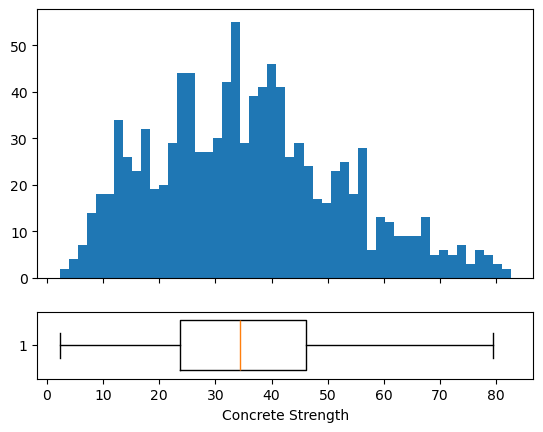

In [7]:
f, axs = pp.subplots(2, 1, gridspec_kw={"height_ratios": [0.8, 0.2]}, sharex=True)
axs[0].hist(df.strength, bins=50, histtype='stepfilled');
axs[1].boxplot(df.strength, orientation='horizontal', showfliers=False, )
axs[1].set_ylim((0.9, 1.1))
axs[1].set_xlabel('Concrete Strength');

Focus on strength as a function of cement and water contents:

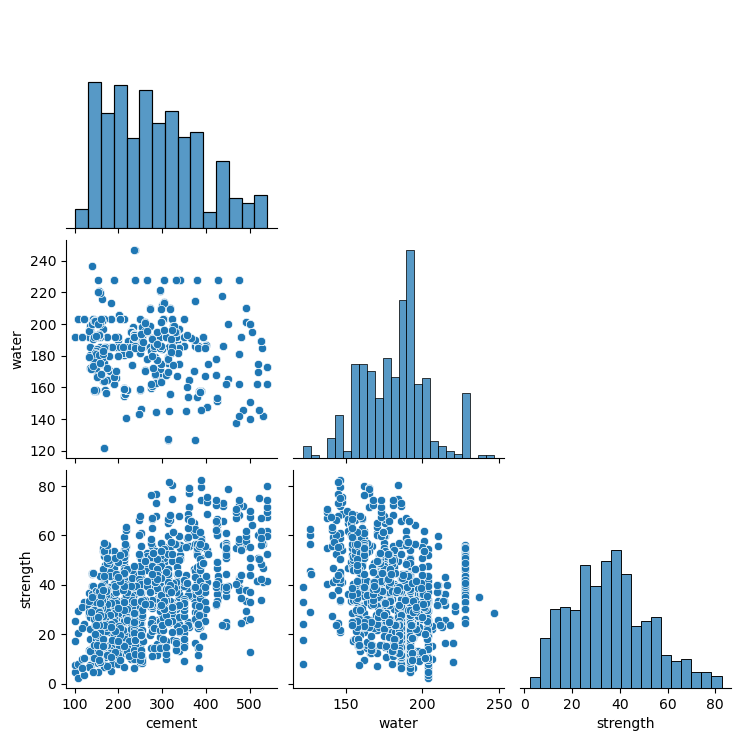

In [8]:
sb.pairplot(df, vars=['cement', 'water', 'strength'], corner=True);

Noticeable plot tendencies:
1. The more the cement, the greater the strength for the observed range
2. The more the water, the lesser the strength
3. Both of the above come with a significant amount of noise, maybe the results of other variables not part of the current focus.
4. Mamy combinations of water and cement amounts were tested, mostly low- to mid-range for water, and primarily mid-range for cement.

Tentative Bayesian Model:

$$ α \sim \mathcal{N}(0, 10)$$
$$ β_{water} \sim \mathcal{N}(0,10)$$ 
$$ β_{cement} \sim \mathcal{N}(0,10)$$ 
$$ σ \sim \mathcal{HalfN(0, 10)}$$
$$ μ_i  = α +β_{water} * Water_i + β_{cement} * Cement_i$$
$$ Strength_i \sim \mathcal{N}(μ_i, σ)$$

1. Modeling Concrete strength as a function of cement and water contents.

In [9]:
with pm.Model() as model_1:
    cement_ = pm.Data('cement', df.cement.to_numpy())
    water_ = pm.Data('water', df.water.to_numpy())
    strength_ = pm.Data('strength', df.strength.to_numpy())
    α = pm.Normal('α', mu=0, sigma=10)
    βc = pm.Normal('βc', mu=0, sigma=10)
    βw = pm.Normal('Βw', mu=0, sigma=10)
    σ = pm.HalfNormal('σ', sigma=10)
    μ = α + βc * cement_ + βw * water_
    pm.Normal('concrete strength', mu=μ, sigma=σ, observed=strength_, shape=μ.shape)

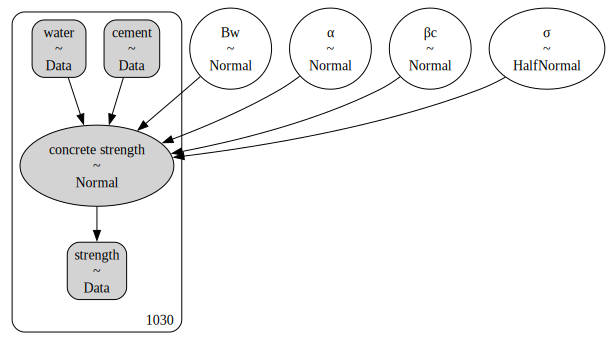

In [10]:
model_1.to_graphviz()

In [11]:
with model_1:
    idata_1 = pm.sample(chains=4, random_seed=1234)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, βc, Βw, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [ ]:
az.plot_trace(idata_1, backend_kwargs={"tight_layout": True});

In [109]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,43.055,3.808,35.763,50.194,0.094,0.067,1644.0,1776.0,1.0
βc,0.079,0.004,0.071,0.087,0.000,0.000,2610.0,2347.0,1.0
Βw,-0.163,0.019,-0.197,-0.123,0.000,0.000,1885.0,1880.0,1.0
σ,13.924,0.304,13.376,14.490,0.006,0.004,2893.0,2480.0,1.0


Fit Observations and Preliminary Conclusions:
* Chains are well mixed, posteriors converge, parameter space well-sampled, fit is good.
* Average Concrete Strength when neither water or cement are used is around 43 MPa
* Concrete Strength increases at the rate of $0.08 \ MPa$ on average for each $kg/m^3$ added.
* Concrete Strength decreases at the rate of $0.16 \ MPa$ on average for each $L/m^3$ added.

In [111]:
new_cement = np.array([300, 400, 500])
new_water = np.array([140, 160, 180])
new_cement, new_water = np.meshgrid(new_cement, new_water)
with model_1:
    pm.set_data(
        {
            'cement': new_cement.ravel(),
            'water': new_water.ravel()
        }
        )

In [112]:
pm.sample_posterior_predictive(idata_1, model=model_1, extend_inferencedata=True, predictions=True)

Sampling: [concrete strength]


Output()

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

AttributeError: Line2D.set() got an unexpected keyword argument 'height'

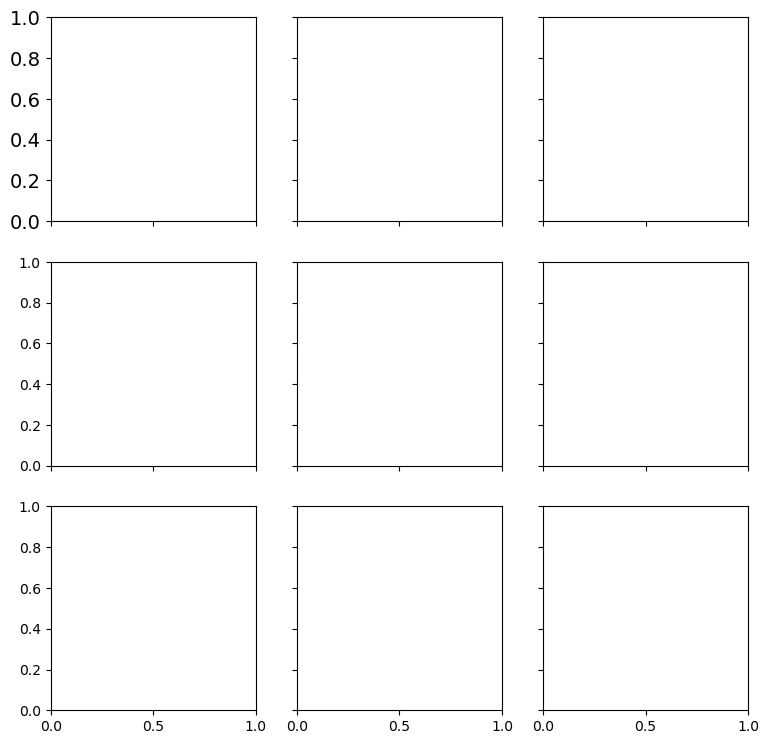

In [120]:
f, axs = pp.subplots(3, 3, figsize=(9,9), sharey=True, sharex=True)
for i, (ax, c, v) in enumerate(zip(axs.ravel(), new_cement.ravel(), new_water.ravel())):
    prediction = idata_1.predictions['concrete strength'].sel({"concrete strength_dim_2": i}).to_numpy().flatten()
    az.plot_kde(prediction,  rug=True, ax=ax, fill_kwargs={"color": 'gray', "alpha": 0.5} , rug_kwargs={'height': 0.2})
    ax.set_yticks([])
    if i%3 == 0:
        ax.set_ylabel(f'Water: {v} L/m3',fontdict={"size": 10})
    if i<3:
        ax.set_title(f'Cement: {c} kg/m3', fontdict={"size": 10})
    if i > 5:
        ax.set_xlabel(f'Strength (MPa)', fontdict={"size": 10})
